In [26]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
# Load the MNIST dataset and explore the file
mnist = scipy.io.loadmat('mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [3]:
# Separate features and labels
X = mnist['data']
y = mnist['label']

In [4]:
# Check the shape of features and labels
print(X.shape)
print(y.shape)

(784, 70000)
(1, 70000)


In [5]:
# Transpose both features and labels so that each row represents an image
X = X.transpose()
y = y.transpose()

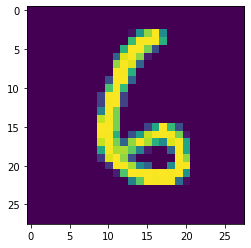

In [6]:
# Visualise an image to test
img_idx = 41000
plt.imshow(np.reshape(X[img_idx,:], (28,28)))

In [7]:
# Split the data into a training and testing sets
r = 4
X_train, X_test, y_train, y_test = train_test_split(X, 
                y, test_size=0.2, random_state=r)

# Further split the testing set into testing and final validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, 
               y_test, test_size=0.2, random_state=r)

In [22]:
# Create a ranom forest model
clf = RandomForestClassifier()

# Check parameters
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [23]:
# Fit the model and predict the labels based on the test features set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

<ipython-input-23-e2cd04fe1d43>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [25]:
# Check accuracy of the current model 
print("Accuracy score: ",accuracy_score(y_test, y_pred))

# Print the max depth of the individual trees in the model
print([estimator.tree_.max_depth for estimator in clf.estimators_])

Accuracy score:  0.9690178571428572
[36, 35, 32, 37, 37, 30, 34, 36, 39, 31, 41, 29, 33, 35, 39, 31, 27, 32, 29, 29, 33, 36, 32, 34, 34, 38, 33, 39, 33, 39, 40, 35, 38, 38, 30, 38, 35, 37, 31, 36, 35, 30, 36, 40, 32, 33, 32, 30, 35, 32, 36, 33, 36, 39, 34, 32, 38, 26, 28, 35, 32, 37, 40, 33, 37, 32, 32, 28, 32, 39, 30, 35, 29, 34, 31, 30, 29, 35, 32, 32, 36, 40, 42, 31, 37, 31, 37, 33, 40, 36, 35, 39, 32, 36, 35, 30, 31, 41, 33, 33]


### The accuracy score is high (>0.95). It looks like a lot of the individual trees have a depth of over 30. To avoid overfitting, I will try to tune the max depth parameter. 

In [27]:
# Use a grid search cv method to tune random forest parameters

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 5, stop = 30, num = 10)]

# Create the random grid
random_grid = {'max_depth': max_depth}

# Create a random forest model with tuned estimators and max depth
rf_random = RandomizedSearchCV(estimator = forest, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

# Print the accuracy
print("Accuracy of tuned random forest:",rf_random.score(X_test, y_test))

# Check which parameters were used
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/joannascharoch/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/joannascharoch/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Accuracy of tuned random forest: 0.9683928571428572


{'max_depth': 30}

In [28]:
# Create a tuned model using the max depth returned as best from the randomised search cv
clf_tuned = RandomForestClassifier(max_depth=30)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict the labels from the final validation set
y_pred_tuned = clf.predict(X_val)

<ipython-input-28-e0cac49c71f7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


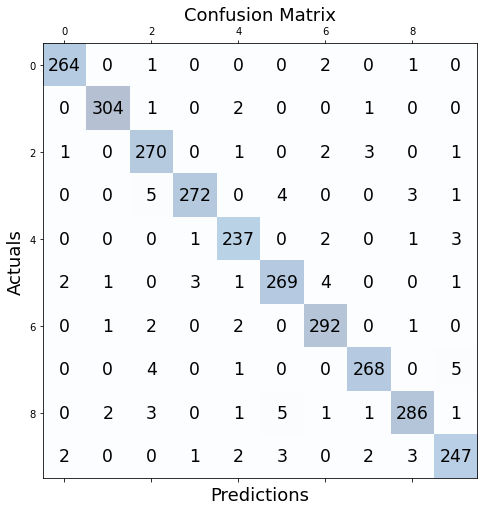

In [29]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred_tuned)

# Visualise the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [30]:
# Print the accuracy, precision, recall and f1 scores of the model
print("Accuracy score: ",accuracy_score(y_val, y_pred_tuned))
print("Precision scores: ",precision_score(y_val, y_pred_tuned, average=None, labels=[0,1,2,3,4,5,6,7,8,9]))
print("Recall scores: ",recall_score(y_val, y_pred_tuned, average=None, labels=[0,1,2,3,4,5,6,7,8,9]))
print("F1 scores: ",f1_score(y_val, y_pred_tuned, average=None, labels=[0,1,2,3,4,5,6,7,8,9]))

Accuracy score:  0.9675
Precision scores:  [0.98141264 0.98701299 0.94405594 0.98194946 0.95951417 0.95729537
 0.96369637 0.97454545 0.96949153 0.95366795]
Recall scores:  [0.98507463 0.98701299 0.97122302 0.95438596 0.97131148 0.95729537
 0.97986577 0.96402878 0.95333333 0.95      ]
F1 scores:  [0.98324022 0.98701299 0.95744681 0.96797153 0.96537678 0.95729537
 0.97171381 0.96925859 0.96134454 0.95183044]


### Based on the confusion matrix and the f1 score, which combines both recall and precision, I can see that the model struggled the most with numbers 2, 5 and 9. 
### Precision score was the lowest for the number 2, meaning other numbers tended to be falsely recognised as 2. Recall score was the lowest for number 9, meaning more true 9s were recognised as other numbers